## [Interpolate](https://easy.gems.dkrz.de/Processing/healpix/regridding.html) to GridSat grid from Healpix level 10

For Mapes 2025 figure making 

In [65]:
### Import Packages: so many, gathered here 

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

## HEALPix Specific
import healpy as hp
import healpix
import easygems.healpix as egh
import easygems.remap as egr

import uxarray as ux 

import cartopy.crs as ccrs
import cartopy.feature as cf
import cmocean

# Package for interpolation routine: (Could use XESMF)
from scipy.interpolate import griddata

In [66]:
import intake
# catalogue from which node? 
cat = intake.open_catalog("https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml")["NCAR"]

In [64]:
list(cat)

['CERES_EBAF',
 'ERA5',
 'IR_IMERG',
 'JRA3Q',
 'MERRA2',
 'arp-gem-1p3km',
 'arp-gem-2p6km',
 'casesm2_10km_nocumulus',
 'icon_d3hp003',
 'icon_d3hp003aug',
 'icon_d3hp003feb',
 'icon_ngc4008',
 'ifs_tco3999-ng5_deepoff',
 'ifs_tco3999-ng5_rcbmf',
 'ifs_tco3999-ng5_rcbmf_cf',
 'ifs_tco3999_rcbmf',
 'mpas_dyamond1',
 'mpas_dyamond2',
 'mpas_dyamond3',
 'nicam_220m_test',
 'nicam_gl11',
 'scream-dkrz',
 'scream2D_hrly',
 'scream_lnd',
 'scream_ne120',
 'tracking-d3hp003',
 'um_Africa_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_CTC_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_SAmer_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_SEA_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_glm_n1280_CoMA9_TBv1p2',
 'um_glm_n1280_GAL9',
 'um_glm_n2560_RAL3p3',
 'wrf_conus',
 'wrf_samerica']

In [103]:
ds = cat.scream2D_hrly(zoom=10).to_dask()
ds

/glade/u/apps/opt/conda/envs/2025-digital-earths-global-hackathon/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


<xarray.Dataset> Size: 952GB
Dimensions:   (crs: 0, time: 9457, cell: 12582912)
Coordinates:
  * crs       (crs) float64 0B 
  * time      (time) object 76kB 2019-08-01 00:00:00 ... 2020-09-01 00:00:00
Dimensions without coordinates: cell
Data variables:
    pr        (time, cell) float32 476GB dask.array<chunksize=(24, 262144), meta=np.ndarray>
    rlut      (time, cell) float32 476GB dask.array<chunksize=(24, 262144), meta=np.ndarray>
    ELEV      (cell) float32 50MB dask.array<chunksize=(4096,), meta=np.ndarray>
    LANDFRAC  (cell) float32 50MB dask.array<chunksize=(4096,), meta=np.ndarray>
    lat       (cell) float32 50MB dask.array<chunksize=(4096,), meta=np.ndarray>
    lon       (cell) float32 50MB dask.array<chunksize=(4096,), meta=np.ndarray>
Attributes: (12/22)
    Conventions:                  CF-1.8
    atm_initial_conditions_file:  /lustre/orion/cli115/world-shared/e3sm/inpu...
    averaging_frequency:          1
    averaging_frequency_units:    nhours
    averaging_type:               INSTANT
    case:                         cess-control.ne1024pg2_ne1024pg2.F2010-SCRE...
    ...                           ...
    product:                      model-output
    realm:                        atmos
    run_t0:                       2019-08-01-00000
    source:                       E3SM Atmosphere Model (EAMxx)
    topography_file:              /lustre/orion/cli115/world-shared/e3sm/inpu...
    username:                     noel

In [227]:
# Afternoons, grab lwut and convert to Tb. Make jday and hour variables. 

ds['jday'] = ds['time'].dt.dayofyear
ds['hour'] = ds['time'].dt.hour

afternoons = ds.sel( {'time': ds.hour.isin([14,17,20,23])} )
summerafts = afternoons.sel(time=afternoons.time.dt.dayofyear < 121)  # JFMA retained 

olr = summerafts.rlut
Tb = np.sqrt(np.sqrt(olr/5.67e-8))

Tb

<xarray.DataArray 'rlut' (time: 472, cell: 12582912)> Size: 24GB
dask.array<sqrt, shape=(472, 12582912), dtype=float32, chunksize=(22, 262144), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 4kB 2020-01-01 14:00:00 ... 2020-04-30 23:00:00
Dimensions without coordinates: cell

In [174]:
# Now spatial subset by pixels in my  lat-lon box
lon = np.arange(360-75,360-40,0.1)
lat = np.arange(-20,0,0.1)

pix = xr.DataArray(
    hp.ang2pix(ds.crs.healpix_nside, *np.meshgrid(lon, lat), nest=True, lonlat=True),
    coords=(("lat", lat), ("lon", lon)))

In [157]:
#egh.healpix_show( olr[1000] )

In [172]:
# Brian IR cell finder functions 
# Tools for cell finder 

from scipy.ndimage import gaussian_filter, minimum_filter

def find_local_minima(data, sigma=1.0, neighborhood_size=3):
    # Find local minima using a minimum filter
    minima = data == minimum_filter(data, footprint=np.ones((neighborhood_size, neighborhood_size)))
    return minima

def smooth_array(data, sigma=1.0):
    smoothed_data = gaussian_filter(data, sigma=sigma)
    return smoothed_data

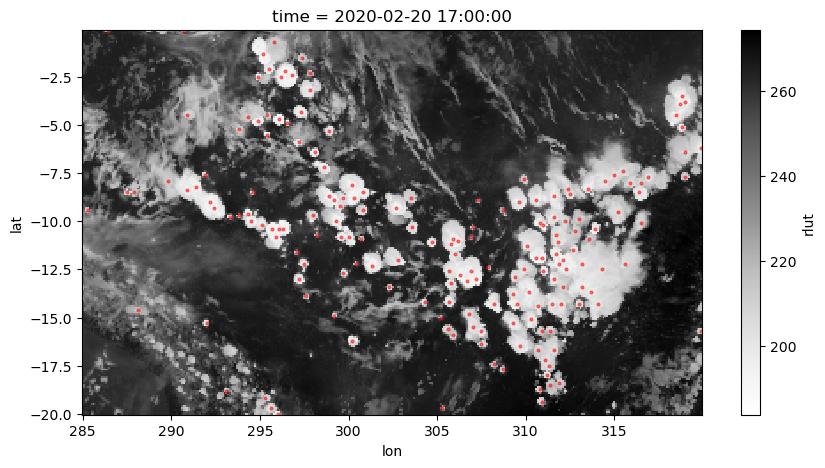

In [298]:
jday = 50
image = Tb.isel(cell=pix,time= 4*jday + 1)

IRTHRESHOLD = 273-60 # Kelvin

minima = find_local_minima( smooth_array(image, sigma=1) )
coldminima = minima & (image.values < IRTHRESHOLD)
cells = np.where(coldminima) # tuple of locations, y in [0] and x in [1] oddly

image.plot(cmap='Greys', size=5, aspect=2)
plt.scatter( image.lon[cells[1]] , image.lat[cells[0]], c='red', alpha=0.5, s=4 );

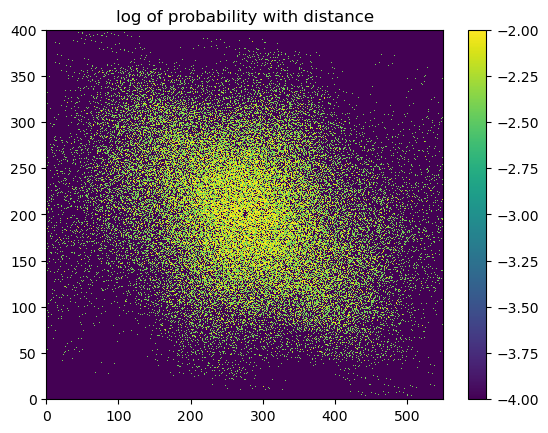

In [183]:
# TEST condprob ON ONE TIME LEVEL 
# Loop over locations, roll the array, and tally the sum of a categorical (0 or 1) array

padded = np.pad(coldminima, 100)

composite_sum = padded*0.0
composite_num = 0.0   # no need for array like int(ccold.values *0) unless there are missing data 

# Locations to center the composite around 
i_vals, j_vals = np.where(padded) 
NX,NY = padded.shape
halfNX = int(NX/2); halfNY = int(NY/2)

# Loop over locations, roll the array, and tally the sum 
for active in range( len(i_vals) ):
    rolled = np.roll(padded, (halfNX-i_vals[active], halfNY-j_vals[active]), axis=(0, 1))
    composite_sum += rolled
    composite_num += 1.0 

# Final result:
composite = composite_sum / composite_num

# Plot it: 
plt.pcolormesh(np.log10(composite + 1e-99), vmin=-4, vmax=-2 ); plt.colorbar(); 
plt.title('log of probability with distance');

In [228]:
# 360 times (90 days, 4 times each day) 

NDAY = 90   # Make sure dataset is large enough to add a week for independent sample
NHOUR = 4
ny,nx = image.shape[0],image.shape[1]
coldminima = np.zeros( (NDAY,NHOUR,ny,nx) )
coldminima_indep = coldminima  # Independent days, same clock hour. Let's just add 7 days for "independence"

# Loop over 90 days
for jday in np.arange(90): 
    print(jday)
    for ihour in np.arange(4): 
        # Grab the image 
        image = Tb.isel(cell=pix,time= 4*jday + ihour)
        print(image.time.values)
        
        # find the cells (cold-enough minima) 
        minima = find_local_minima( smooth_array(image, sigma=1) )
        coldmin = minima & (image.values < IRTHRESHOLD)
        cells = np.where(coldmin) # tuple of locations, y in [0] and x in [1] oddly
        coldminima[jday,ihour,:,:] = coldmin

        # Grab the independent image 
        image = Tb.isel(cell=pix,time= 4*jday + ihour   +28) # Add a week, so weather is independent
        
        # find the cells (cold-enough minima) 
        minima = find_local_minima( smooth_array(image, sigma=1) )
        coldmin = minima & (image.values < IRTHRESHOLD)
        cells = np.where(coldmin) # tuple of locations, y in [0] and x in [1] oddly
        coldminima_indep[jday,ihour,:,:] = coldmin

0
2020-01-01 14:00:00
2020-01-01 17:00:00
2020-01-01 20:00:00
2020-01-01 23:00:00
1
2020-01-02 14:00:00
2020-01-02 17:00:00
2020-01-02 20:00:00
2020-01-02 23:00:00
2
2020-01-03 14:00:00
2020-01-03 17:00:00
2020-01-03 20:00:00
2020-01-03 23:00:00
3
2020-01-04 14:00:00
2020-01-04 17:00:00
2020-01-04 20:00:00
2020-01-04 23:00:00
4
2020-01-05 14:00:00
2020-01-05 17:00:00
2020-01-05 20:00:00
2020-01-05 23:00:00
5
2020-01-06 14:00:00
2020-01-06 17:00:00
2020-01-06 20:00:00
2020-01-06 23:00:00
6
2020-01-07 14:00:00
2020-01-07 17:00:00
2020-01-07 20:00:00
2020-01-07 23:00:00
7
2020-01-08 14:00:00
2020-01-08 17:00:00
2020-01-08 20:00:00
2020-01-08 23:00:00
8
2020-01-09 14:00:00
2020-01-09 17:00:00
2020-01-09 20:00:00
2020-01-09 23:00:00
9
2020-01-10 14:00:00
2020-01-10 17:00:00
2020-01-10 20:00:00
2020-01-10 23:00:00
10
2020-01-11 14:00:00
2020-01-11 17:00:00
2020-01-11 20:00:00
2020-01-11 23:00:00
11
2020-01-12 14:00:00
2020-01-12 17:00:00
2020-01-12 20:00:00
2020-01-12 23:00:00
12
2020-01-13 

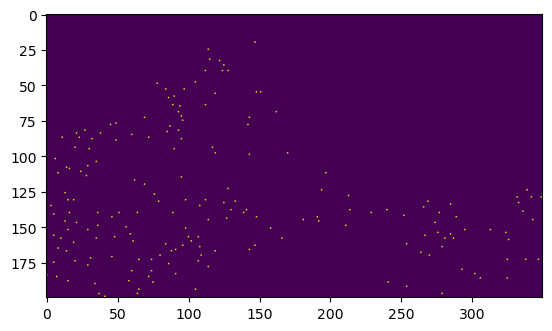

In [231]:
plt.imshow(coldminima[89,3])

In [243]:
pad_cells.shape

(90, 4, 400, 550)

In [254]:
# Found all cells, now make conditional frequency arrays (results), ones not zeros so division never fails 

results   = np.ones( (4,4,NX,NY) ) # central 286x286 box of composite space, for all 5 times of day, with basetimes [0,4], for all 4 cases
results2  = np.ones( (4,4,NX,NY) ) # independent image a week later, same climo but decoupled from cell day 

# Padding around horizontal edges to avoid cylic adjacency, but not in time (day and hour)
pad_cells = np.pad(coldminima ,      ((0,0),(0,0),(100,100),(100,100)) )
pad_cells2= np.pad(coldminima_indep, ((0,0),(0,0),(100,100),(100,100)) )

################ OK we have coldminima and coldminima_indep, and padded versions.
# We can make the same-year composites (results), and cross-year (results2)
NX,NY = pad_cells[0,0,:,:].shape
halfNX = int(NX/2); halfNY = int(NY/2)
        
# Begin composite building: loop over all the base hours 0,1,2,3   
for ibase,basetime in enumerate( range(NHOUR) ):  
        print('Base hour ', ibase) 

# Loop over days, adding up the Boolean cell=True array at this base hour, but also at other hours 
# results is (4,4,NX,NY) where the 4 are base hour and all hours 
        for iday,day in enumerate( range(NDAY) ):  
            # print('Days ', iday) 

# Locations to center the composite around: "cells" in an "image" drawn from unpadded IR286
            i_vals, j_vals = np.where( pad_cells [iday,ibase,:,:] ) # locations of all "cells" in (coldminima)
            i_vals2,j_vals2= np.where( pad_cells2[iday,ibase,:,:] ) # locations of all "cells" in (coldminima_indep)
            
# Loop over cell locations at this iday,ihour pair. 
# Roll the padded data for all 4 hours at once with (0, :, halfNX-i_vals[cell], halfNY-j_vals[cell])
            for cell in range( len(i_vals) ):       
                # for the reference image (central conditional cell), roll this day's padded cells [4,NX,NY] 
                rolled = np.roll(pad_cells[iday,:,:,:], (0, halfNX-i_vals[cell], halfNY-j_vals[cell]), axis=(0,1,2) )
                results[ibase,:,:,:]  +=  rolled 

                # for the independent-day's cells, do the same for results2 
                rolled = np.roll(pad_cells2[iday,:,:,:], (0, halfNX-i_vals[cell], halfNY-j_vals[cell]), axis=(0,1,2) )
                results2[ibase,:,:,:] +=  rolled 

            
# Loop over cells in i_vals2 (the WEEK+1 cells). Roll the padded data for all 5 time levels at once. 
# This doubles sample size, since minus one week and plus one week are equally independent.  
            for cell in range( len(i_vals2) ):       
                # for the SAME year (here the +1 year, pad_cells2 arreay and ivals2 index
                rolled = np.roll(pad_cells2[iday,:,:,:], (0, halfNX-i_vals2[cell], halfNY-j_vals2[cell]), axis=(0,1,2) )
                results[ibase, :,:,:] +=  rolled 
                # for the OTHER year (here the MCS year, pad_cells and ivals index
                rolled = np.roll(pad_cells[iday,:,:,:] , (0, halfNX-i_vals2[cell], halfNY-j_vals2[cell]), axis=(0,1,2) )
                results2[ibase, :,:,:] +=  rolled 
                

0 0
0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
10 10
11 11
12 12
13 13
14 14
15 15
16 16
17 17
18 18
19 19
20 20
21 21
22 22
23 23
24 24
25 25
26 26
27 27
28 28
29 29
30 30
31 31
32 32
33 33
34 34
35 35
36 36
37 37
38 38
39 39
40 40
41 41
42 42
43 43
44 44
45 45
46 46
47 47
48 48
49 49
50 50
51 51
52 52
53 53
54 54
55 55
56 56
57 57
58 58
59 59
60 60
61 61
62 62
63 63
64 64
65 65
66 66
67 67
68 68
69 69
70 70
71 71
72 72
73 73
74 74
75 75
76 76
77 77
78 78
79 79
80 80
81 81
82 82
83 83
84 84
85 85
86 86
87 87
88 88
89 89
1 1
0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
10 10
11 11
12 12
13 13
14 14
15 15
16 16
17 17
18 18
19 19
20 20
21 21
22 22
23 23
24 24
25 25
26 26
27 27
28 28
29 29
30 30
31 31
32 32
33 33
34 34
35 35
36 36
37 37
38 38
39 39
40 40
41 41
42 42
43 43
44 44
45 45
46 46
47 47
48 48
49 49
50 50
51 51
52 52
53 53
54 54
55 55
56 56
57 57
58 58
59 59
60 60
61 61
62 62
63 63
64 64
65 65
66 66
67 67
68 68
69 69
70 70
71 71
72 72
73 73
74 74
75 75
76 76
77 77
78 78
79 79
80 80
81 81


In [255]:
results.shape

(4, 4, 400, 550)

In [260]:
# Convert tallies (results) to conditional probability units (normalize)

condprob = results.copy() # right shaped container, initially a copy  
condprob2 = results2.copy() # right shaped container, initially a copy  

for it1 in range(4): 
    for it2 in range(4): 
        condprob [it1,it2,:,:] /= np.sum( condprob [it1,it2,:,:] )
        condprob2[it1,it2,:,:] /= np.sum( condprob2[it1,it2,:,:] )

#        if( it1==it2 ): 
#            condprob[:,:,:,143,143] = 0  # exclude spike at origin at base time, want *other cell* condprob
               
# simple check 
condprob2[2,1,:,:].sum()

np.float64(0.9999999999999998)

In [278]:
condprob.shape

(4, 4, 400, 550)

In [280]:
# make coordinates (dimensions) for xarray, so we can easily use groupby_bins for all cases and times

# print( ds.lat.diff(dim='lat').mean().values )  # 0.07 degrees, 7.7777 km near the equator
x = (np.linspace(-halfNX,halfNX,NX))*7.77 ### These are km units ignoring cos(lat) 
y = (np.linspace(-halfNY,halfNY,NY))*7.77 ### These are km units
LST = np.array( range(4) )*3+14   # 3 hourly time index, contrived to end at 23Z in SAmerica and 9Z in SPCZ (evening LST)
basetime = np.array( range(4) )*3 +14

In [282]:
# make xarray DataArray, and then Dataset. Write it out if desired

p_othercell = xr.DataArray(condprob, \
        coords={'basetime':basetime,'clockhour':LST, 'x': x,'y': y}, 
        dims=["basetime","clockhour","x", "y"] )
p_othercell2 = xr.DataArray(condprob2, \
        coords={'basetime':basetime,'clockhour':LST, 'x': x,'y': y}, 
        dims=["basetime","clockhour","x", "y"] )

p_othercell = p_othercell.to_dataset( name="spatialp_of_another_cell" )
p_othercell['condprob2'] = p_othercell2

p_othercell
# p_othercell.to_netcdf('Tb_cell_CondProbResults.nc') # 


<xarray.Dataset> Size: 56MB
Dimensions:                   (basetime: 4, clockhour: 4, x: 400, y: 550)
Coordinates:
  * basetime                  (basetime) int64 32B 14 17 20 23
  * clockhour                 (clockhour) int64 32B 14 17 20 23
  * x                         (x) float64 3kB -1.554e+03 ... 1.554e+03
  * y                         (y) float64 4kB -2.137e+03 ... 2.137e+03
Data variables:
    spatialp_of_another_cell  (basetime, clockhour, x, y) float64 28MB 2.13e-...
    condprob2                 (basetime, clockhour, x, y) float64 28MB 2.13e-...

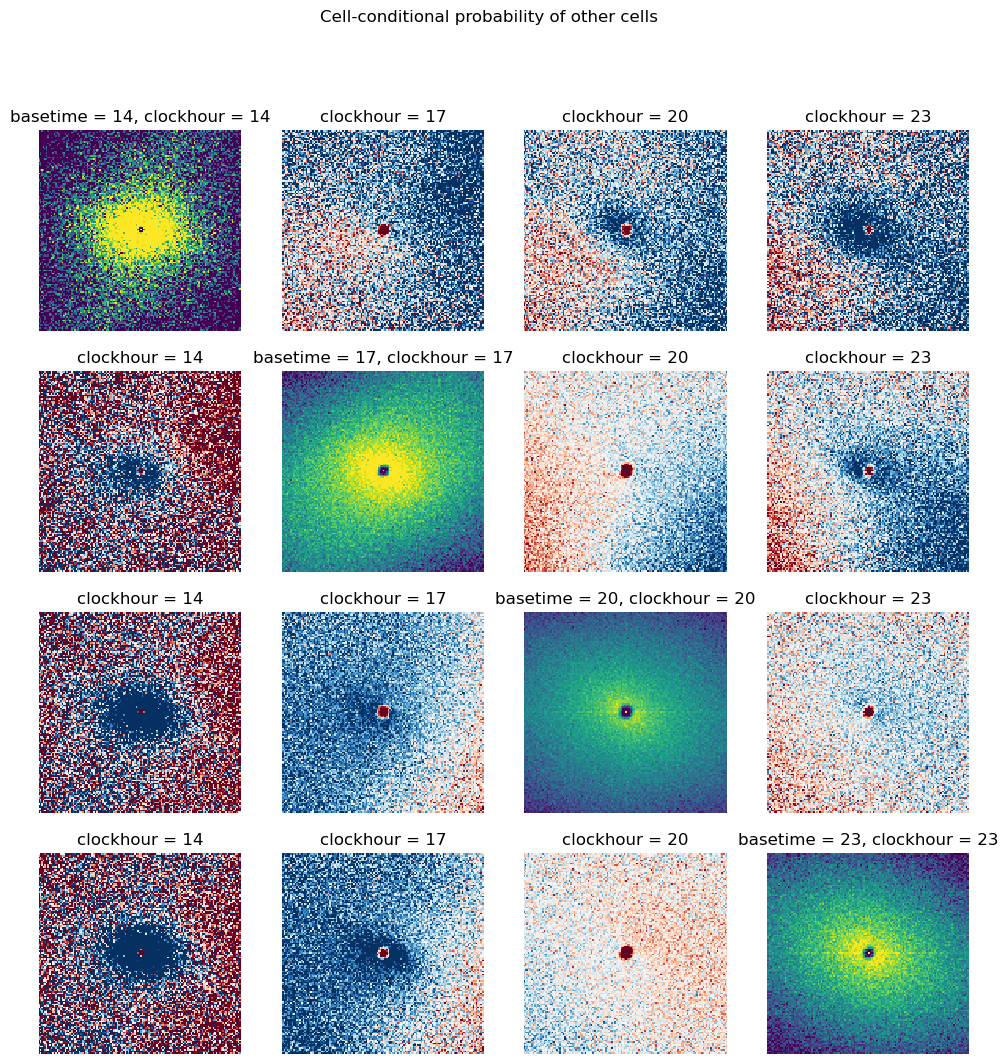

In [296]:
    # logp differences (log of ratio): conditional on other t vs. unconditional at t

    plt.figure( figsize = (12,12) ) 
    plt.suptitle('Cell-conditional probability of other cells')
    size = [-500,500] # km 
    
    for ibt in range(4): 
        for it in range(4): 
            # pool by summing MCS and +1year samples. 
            # Denominator is other-year (condprob2), with no bullseye 
            # These p arrays should sum to 1 so average them (divide by 2) 
            
            sum1 =  (p_othercell.spatialp_of_another_cell[ibt,it,:,:] + \
                     p_othercell.spatialp_of_another_cell[ibt,it,:,:])/2. 
            sum2 =  (p_othercell.condprob2[it,it,:,:] + \
                     p_othercell.condprob2[it,it,:,:])/2.
            
            ratio = sum1/sum2 
            
            plt.subplot(4,4,ibt*4 + it +1)
            if(ibt == it): # total probability for each clock time it 
                np.log2( sum1+1e-99 ).plot( vmin=-17, vmax=-15, cmap='viridis' , add_colorbar=False)
            else:  # conditional probability divided by total **at that it hour**|
                np.log2( ratio+1e-99  ).plot( vmin=-0.8, vmax=0.8, cmap='RdBu_r' , add_colorbar=False)
  
            plt.axis('off')
            plt.xlim(size); plt.ylim(size); 
            #plt.title(b=' +str(SUTCs[ibt]) +', h=' +str(SUTCs[it]) )

In [290]:
ratio.shape

(400, 550)

In [53]:
ds_with_coords = hs.add_latlon_coords(olr.to_dataset())

/glade/u/home/mapes/healpix_selection.py:71: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  pixel_indices = np.arange(ds.dims['cell'])


In [55]:
ds_with_coords.lon.max()

<xarray.DataArray 'lon' ()> Size: 8B
array(179.95605469)
Coordinates:
    crs      float32 4B nan

In [ ]:
# Brian IR cell finder 
# TEST IMAGE and "cells" (minima)

IRTHRESHOLD = 273-40 

image = ds.irwin_cdr[4]
minima = find_local_minima( smooth_array(image, sigma=1) )
coldminima = minima & (image.values < IRTHRESHOLD)
cells = np.where(coldminima) # tuple of locations, y in [0] and x in [1] oddly

# Slice lat to -20,15
image.sel(lat=slice(-20,0),lon=slice(-80,-40)).plot(cmap='Greys', size=5, aspect=1.6)
plt.scatter( ds.lon[cells[1]] , ds.lat[cells[0]], c='red', alpha=0.5, s=4 );
coastline()